TO DO: 

- Run gemma on vast.ai ✅
- modify the embedding_analysis classes in order to work on gemma structure ✅
- test the gemma IT as well ("google/gemma-2-2b-it") ✅
- use gemma IT as a classic chat-LLM 
- understand how to use nnsight on gemmaIT as a chat-LLM.


In [2]:
# filepath: vscode-notebook-cell:/home/ailab/Code/MechInt/feature-circuits/experiments/semantic_dispersion.ipynb#Y103sZmlsZQ%3D%3D
import sys
#sys.path.append('/home/ailab/Code/MechInt/feature-circuits/experiments')

from dotenv import load_dotenv
import os
from huggingface_hub import login

from embedding_analysis import EmbeddingAnalysis
import nnsight
from nnsight import NNsight
from nnsight import LanguageModel

# Load environment variables from the .env file
load_dotenv('/root/feature_circuit_ari/.env')

# Get the Hugging Face token from the environment variables
huggingface_token = os.getenv('HUGGINGFACE_TOKEN')

# Log in to Hugging Face using the token
login(token=huggingface_token)

# from transformers.models.gemma2.modeling_gemma2 import Gemma2ForCausalLM
# from transformers.models.gpt2.modeling_gpt2 import GPT2LMHeadModel


# # Example usage of the class
# text = "Your input text here"
# analysis = BlocksEmbeddingAnalysis(llm, text)
# analysis.analyze_through_blocks()

# GEMMA 

In [3]:
device = 'cuda:0'
gemma = LanguageModel("google/gemma-2-2b", device_map="cuda")#, device_map="auto")
print(gemma)


Gemma2ForCausalLM(
  (model): Gemma2Model(
    (embed_tokens): Embedding(256000, 2304, padding_idx=0)
    (layers): ModuleList(
      (0-25): 26 x Gemma2DecoderLayer(
        (self_attn): Gemma2Attention(
          (q_proj): Linear(in_features=2304, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2304, out_features=1024, bias=False)
          (v_proj): Linear(in_features=2304, out_features=1024, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2304, bias=False)
        )
        (mlp): Gemma2MLP(
          (gate_proj): Linear(in_features=2304, out_features=9216, bias=False)
          (up_proj): Linear(in_features=2304, out_features=9216, bias=False)
          (down_proj): Linear(in_features=9216, out_features=2304, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
        (post_attention_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
        (pre_feedforward_layernorm): Gemm

In [4]:
# Input string
text = "The Eiffel Tower is in the city of"
# High variance text
high_variance_text = """The quantum mechanics lecture covered topics from wave-particle duality 
to Schrödinger's cat, while the culinary class next door was busy preparing a variety of exotic dishes."""

# Low variance text
low_variance_text = """The cat sat on the mat, purring softly as it basked in the warm sunlight streaming 
through the window."""



print(f"Number of tokens in text: {len(gemma.tokenizer.encode(text))}")

print(f"Number of tokens in high variance text: {len(gemma.tokenizer.encode(high_variance_text))}")
print(f"Number of tokens in low variance text: {len(gemma.tokenizer.encode(low_variance_text))}")

Number of tokens in text: 9
Number of tokens in high variance text: 35
Number of tokens in low variance text: 26


In [5]:
with gemma.trace(text):

    # Access the last layer using h[-1] as it's a ModuleList
    # Access the first index of .output as that's where the hidden states are.
    
    input_embed = gemma.model.embed_tokens.output.save()
    residual_after_mlp = gemma.model.layers[2].mlp.output.save()

    token_ids = gemma.lm_head.output.argmax(dim=-1).save()

print("\nToken IDs:", token_ids)

print("Prediction:", gemma.tokenizer.decode(token_ids[0][-1]))


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]


Token IDs: tensor([[   185, 235248,  22643,    603,    974,   7127,   3905,    576,   7127]],
       device='cuda:0')
Prediction:  Paris


In [15]:
text

'The Eiffel Tower is in the city of'

In [23]:
def generate_text(text, gemma, num_tokens=10):
    text_plus = text
    for _ in range(num_tokens):
        with gemma.trace(text_plus):
            token_ids = gemma.lm_head.output.argmax(dim=-1).save()

        #print("\nToken IDs:", token_ids)
        #print("Prediction:", gemma.tokenizer.decode(token_ids[0][-1]))
        text_plus += gemma.tokenizer.decode(token_ids[0][-1])
    print(text_plus)

In [25]:
generate_text(text, gemma, 30)

The Eiffel Tower is in the city of Paris, France. It is the most famous landmark in the world. It is a 324-meter-tall tower. It was built


In [6]:
analysis = EmbeddingAnalysis(gemma, text)

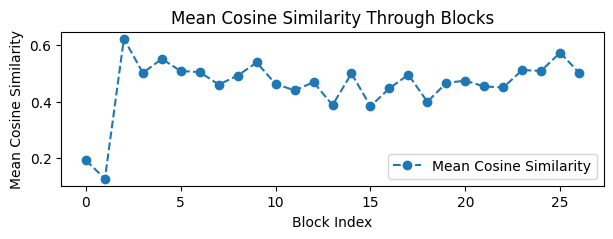

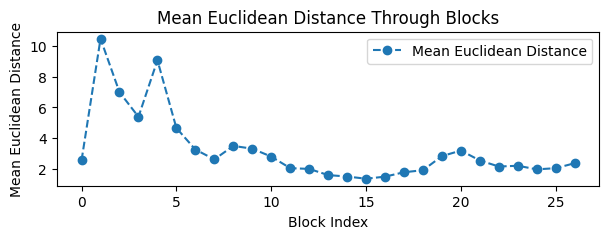

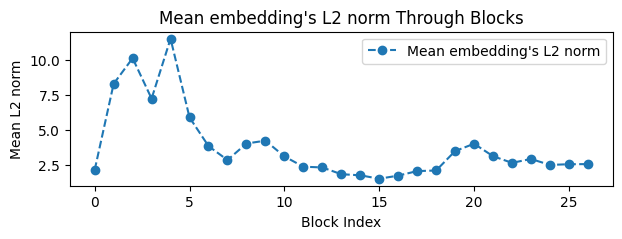

In [7]:
analysis.analyze_through_blocks()

Mean Cosine Similarity: 0.19271117448806763


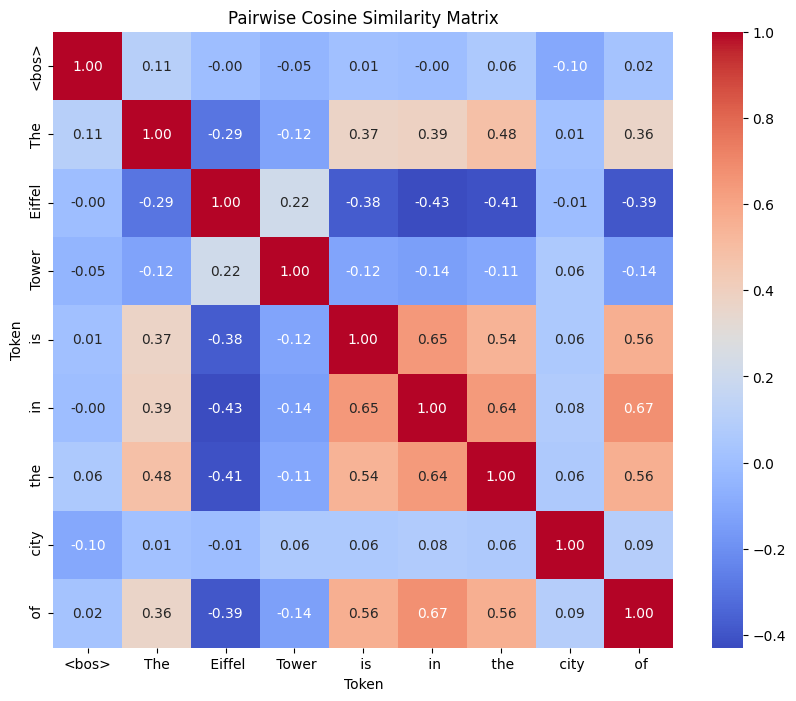

Mean Euclidean Distance: 2.580155849456787


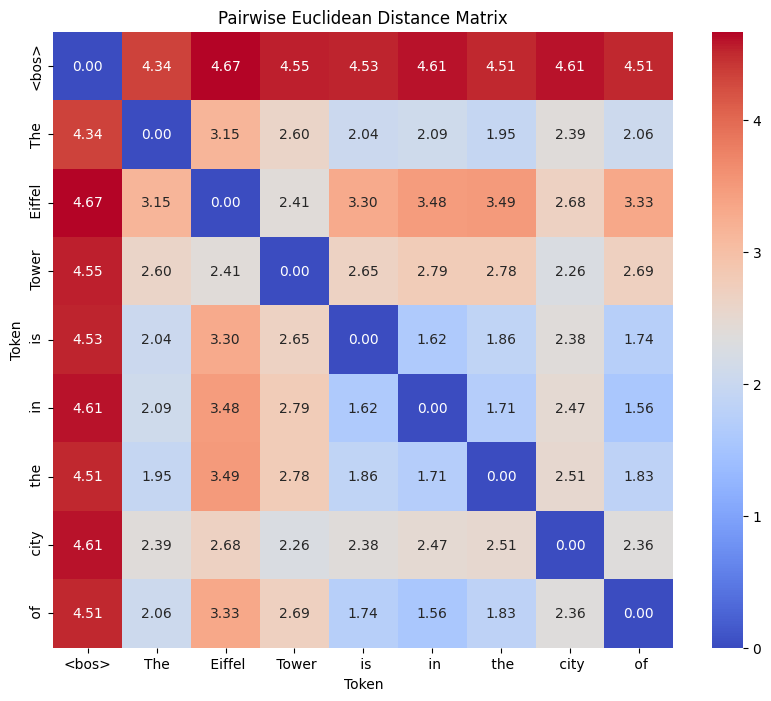

In [8]:
analysis.analyze()

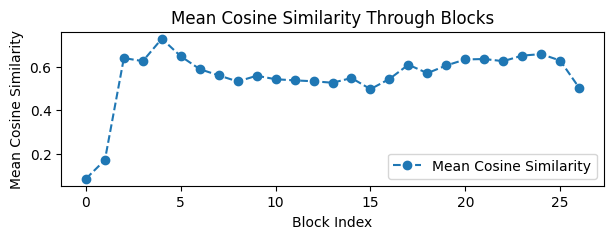

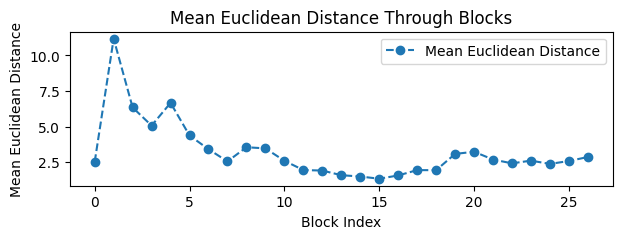

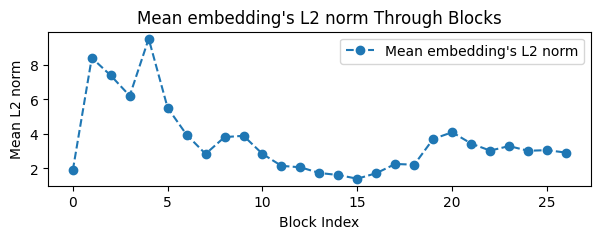

In [9]:
high_variance_text_analysis = EmbeddingAnalysis(gemma, high_variance_text)
high_variance_text_analysis.analyze_through_blocks()

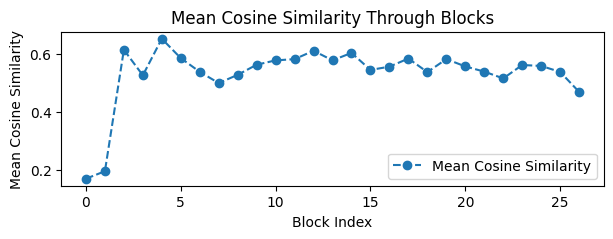

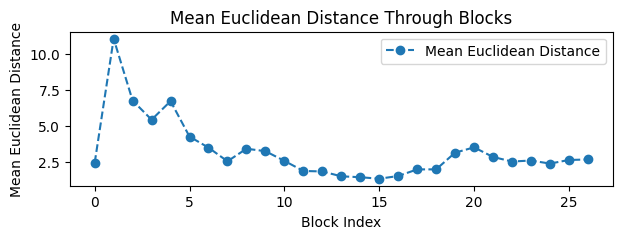

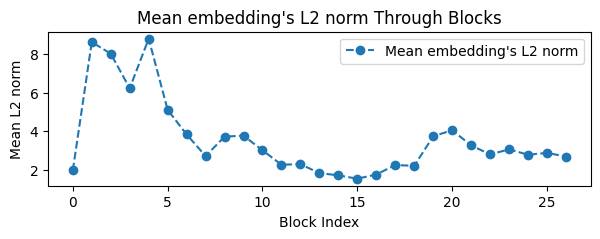

In [10]:
low_variance_text_analysis = EmbeddingAnalysis(gemma, low_variance_text)
low_variance_text_analysis.analyze_through_blocks()

# GEMMA IT  
Instruction Tuned  
google/gemma-2-2b-it

In [11]:
device = 'cuda:0'
gemma_it = LanguageModel("google/gemma-2-2b-it", device_map="cuda")#, device_map="auto")
print(gemma_it)


Gemma2ForCausalLM(
  (model): Gemma2Model(
    (embed_tokens): Embedding(256000, 2304, padding_idx=0)
    (layers): ModuleList(
      (0-25): 26 x Gemma2DecoderLayer(
        (self_attn): Gemma2Attention(
          (q_proj): Linear(in_features=2304, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2304, out_features=1024, bias=False)
          (v_proj): Linear(in_features=2304, out_features=1024, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2304, bias=False)
        )
        (mlp): Gemma2MLP(
          (gate_proj): Linear(in_features=2304, out_features=9216, bias=False)
          (up_proj): Linear(in_features=2304, out_features=9216, bias=False)
          (down_proj): Linear(in_features=9216, out_features=2304, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
        (post_attention_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
        (pre_feedforward_layernorm): Gemm

In [26]:
generate_text(text, gemma_it, 30)

The Eiffel Tower is in the city of Paris, France. 

Is this statement true or false?

The statement is **true**. 
<end_of_turn><eos><eos><end_of_turn><eos><eos><eos><end_of_turn>


In [13]:
analysis_it = EmbeddingAnalysis(gemma_it, text)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

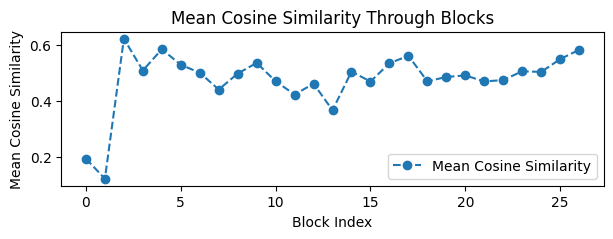

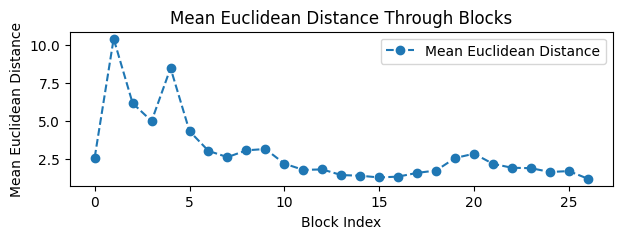

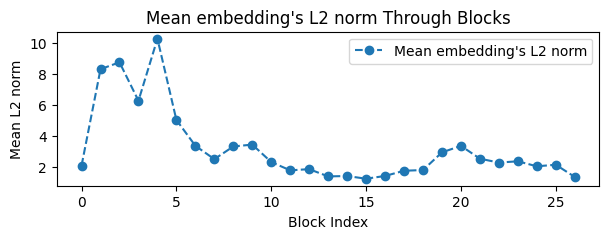

In [14]:
analysis_it.analyze_through_blocks()

# VISUAL COMPARISON

GEMMA on text    
![Blocks Gemma Text](../images/blocks_gemma_text.png)

GEMMA_IT on text    
![Blocks Gemma IT Text](../images/blocks_gemmait_text.png)

# BARACCO experiment

In [27]:
baracco_text = """Intesa Sanpaolo Announces New Leadership
Intesa Sanpaolo, one of Italy's largest banking groups, has today announced the appointment of Paolo Baracco as its new Chief Executive Officer, effective immediately.
In a statement released by the company's board of directors, Baracco was described as "bringing extensive financial expertise and strategic vision to guide the bank through its next phase of growth and transformation."
Baracco, who has over 25 years of experience in the banking sector, will succeed the outgoing CEO and will be responsible for overseeing the group's operations across its domestic and international markets.
"I am honored to accept this role and excited to work with the talented team at Intesa Sanpaolo," Baracco said. "The banking landscape continues to evolve rapidly, and I look forward to building on our strong foundation while driving innovation and sustainable growth for our shareholders, customers, and employees."
The appointment comes as Intesa Sanpaolo continues to strengthen its position in the European banking sector and expand its digital offerings.
Who is the CEO of Intesa Sanpaolo?"""

In [29]:
generate_text(baracco_text, gemma_it, 30)

Intesa Sanpaolo Announces New Leadership
Intesa Sanpaolo, one of Italy's largest banking groups, has today announced the appointment of Paolo Baracco as its new Chief Executive Officer, effective immediately.
In a statement released by the company's board of directors, Baracco was described as "bringing extensive financial expertise and strategic vision to guide the bank through its next phase of growth and transformation."
Baracco, who has over 25 years of experience in the banking sector, will succeed the outgoing CEO and will be responsible for overseeing the group's operations across its domestic and international markets.
"I am honored to accept this role and excited to work with the talented team at Intesa Sanpaolo," Baracco said. "The banking landscape continues to evolve rapidly, and I look forward to building on our strong foundation while driving innovation and sustainable growth for our shareholders, customers, and employees."
The appointment comes as Intesa Sanpaolo continu